In [237]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [238]:
#Iris Localization:

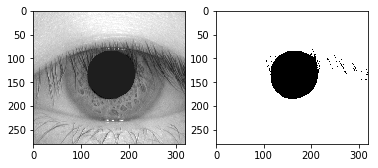

In [275]:
#imgPath = '/Users/sunflower/Desktop'
#imgFilename = "001_1_1.bmp"

#img_filePath = os.path.join(imgPath, imgFilename)
img_color = cv2.imread('/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/004/2/004_2_3.bmp')

#image_gray
image = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
_,image_B1 = cv2.threshold(image,60,65,cv2.THRESH_BINARY)

plt.subplot(1,2,1)
plt.imshow(image, cmap ='gray')
plt.subplot(1,2,2)
plt.imshow(image_B1, cmap ="gray")

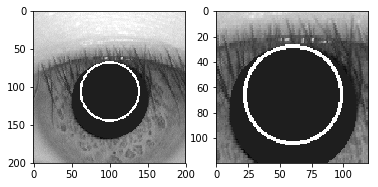

In [273]:
Yp = np.argmin(image_B1.sum(axis = 1))
Xp = np.argmin(image_B1.sum(axis = 0))


#Find the ROI
crop_img = image[max(0,Yp-100):min(Yp+100,320), max(0,Xp-100):min(Xp+100,280)]
#Pupil Area
area120 = image[max(0, Yp-60):min(Yp+60, 320), max(0, Xp-60):min(Xp+60, 280)]

plt.subplot(1,2,1)
plt.imshow(crop_img, cmap ="gray")
plt.subplot(1,2,2)
plt.imshow(area120, cmap ="gray")

In [267]:
_,image_pupil = cv2.threshold(area120,64,255,cv2.THRESH_BINARY)

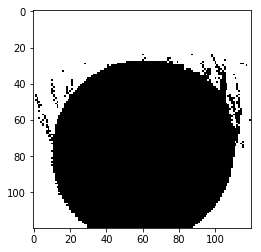

In [268]:
plt.imshow(image_pupil, cmap ="gray")

In [269]:
mask1 = np.where(image_binary>0,1,0)

miny = np.argmin(mask1.mean(axis = 1))
minx = np.argmin(mask1.mean(axis = 0))

radius1 = np.sum(mask1[miny] == 0) / 2
radius2 = np.sum(mask1 == 0,axis=0)[minx] / 2
radius = np.mean([radius1, radius2])

Y1 = np.argmin(image_pupil.sum(axis = 1))
X1 = np.argmin(image_pupil.sum(axis = 0))

In [270]:
print(X1,Y1)

60 66


In [271]:
#Find the inner circles
#circles_inner = cv2.HoughCircles(area120,cv2.HOUGH_GRADIENT,1,250,
#                            param1=50,param2=10,minRadius=int(radius)-1,
#                                 maxRadius=int(radius)+1)

#circles_inner = np.uint16(np.around(circles_inner))

circles_inner = cv2.circle(area120,(X1,Y1), int(radius),[255,0,0],2)

#circles_inner = np.uint16(np.around(circles_inner))

#area120_copy = area120.copy()

#Draw Inner
#for i in circles_inner[0,:]:
#    cv2.circle(area120_copy,(i[0],i[1]),i[2],(0,255,0),2)

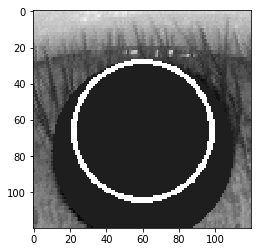

In [272]:
plt.imshow(circles_inner, cmap='gray')

In [261]:
#Find the outer circle
circles_outer = cv2.HoughCircles(crop_img,cv2.HOUGH_GRADIENT,1,250,
                            param1=40,param2=10,minRadius = int(radius)+15,
                                 maxRadius=0)

circles_outer = np.uint16(np.around(circles_outer))

crop_img_copy = crop_img.copy()
img_copy = image.copy()

#Draw Outer
for i in circles_outer[0,:]:
    cv2.circle(crop_img_copy,(i[0],i[1]),i[2],(0,255,0),2)

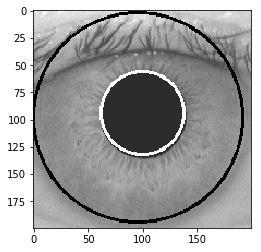

In [262]:
plt.imshow(crop_img_copy, cmap='gray')

In [263]:
crop_img_copy2 = crop_img.copy()

for i in circles_inner[0,:]:
    cv2.circle(crop_img_copy2,(i[0]+40,i[1]+40),i[2],(0,255,0),2) # plus 60 to map to the crop_img
    inner_circle = [i[0]+40,i[1]+40,i[2]]
    
#Draw Outer
for i in circles_outer[0,:]:
    cv2.circle(crop_img_copy2,(i[0],i[1]),i[2],(0,255,0),2)
    outer_circle = [i[0],i[1],i[2]]
    
plt.imshow(crop_img_copy2, cmap='gray')  

IndexError: invalid index to scalar variable.

In [212]:
len(crop_img[0])

200

In [213]:
#Iris Normalization:

In [214]:
M = 64
N = 512

Image_norm = np.zeros((64,512))

[x1, y1, r_inner] = [inner_circle[0], inner_circle[1], inner_circle[2]]
[x2, y2, r_outer] = [outer_circle[0], outer_circle[1], outer_circle[2]]

#distance between the center of puptil to center of the iris
distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)

#angle between the center of puptil to center of the iris
theta_diff = np.arctan2(y2-y1, x2-x1)

#using law of cosines to find the distance between the center of pupil to the outer point
diff_dist_square = distance**2 + r_outer**2 - 2*distance*r_outer*np.cos(theta_diff)
diff_dist = diff_dist_square**0.5

#Using the centroid of pupil as the reference point
for Y in range(0, M):
    for X in range(0, N):
        theta = 2*np.pi*X/N
        x_inner = x1+r_inner*np.cos(theta)
        y_inner = y1+r_inner*np.sin(theta)
        x_outer = x1 + diff_dist * np.cos(theta)
        y_outer = y1 + diff_dist * np.sin(theta)
        x = x_inner + (x_outer - x_inner)*Y/M
        x = int(x)
        x = min(199,x) or max(0,x)
        
        y = y_inner + (y_outer - y_inner)*Y/M
        y = int(y)
        y = min(199,y) or max(0,y)
        
        Image_norm[Y, 511-X] = crop_img[y,x]

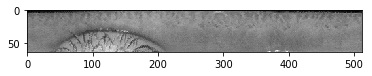

In [215]:
plt.imshow(Image_norm, cmap ='gray')

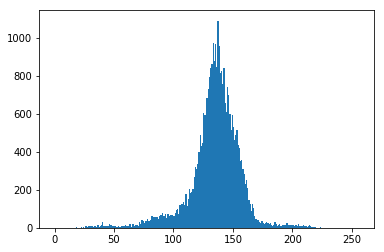

In [18]:
plt.hist(Image_norm.ravel(), 256, [0,256])
plt.show()

In [19]:
#Image Enhancement

In [ ]:
#Detection of eyelashes, then use as a mask to do logic operation
#_,image_eyelash = cv2.threshold(Image_norm, 155, 255, cv2.THRESH_BINARY)
#image_eyelash = cv2.bitwise_not(image_inv)
#plt.imshow(image_eyelash, cmap = 'gray')

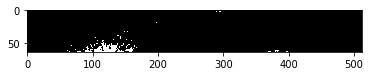

In [283]:
#Detection of reflections, then use as a mask to do logic operation
_,image_reflection = cv2.threshold(Image_norm, 178,255, cv2.THRESH_BINARY)
plt.imshow(image_reflection, cmap = 'gray')

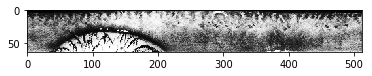

In [282]:
#Image_Equalization
#Image_norm = cv2.cvtColor(Image_norm, cv2.COLOR_BGR2GRAY)

import numpy

image2en = np.array(Image_norm,dtype=np.uint8)
img_histEql = cv2.equalizeHist(image2en)

plt.imshow(img_histEql, cmap = 'gray')
#plt.hist(img_histEql.ravel(),256,[0,256])

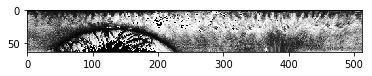

In [22]:
#masks:
image_reflection = np.array(image_reflection,dtype=np.uint8)
mask1 = cv2.bitwise_not(image_reflection)
mask1 = np.array(mask1,dtype=np.uint8)
#image_reflection = np.array(image_reflection,dtype=np.uint8)

noise_removed = cv2.bitwise_and(img_histEql,img_histEql, mask = mask1)
plt.imshow(noise_removed, cmap ="gray")

In [ ]:
plt.imshow(mask1, cmap ="gray")

In [ ]:
#Feature Extraction:
import scipy.signal

roi = noise_removed[0:48,:]

f = 1/1.5  # how should we determine the frequency value
sigx_1 = 3
sigy_1 = 1.5

sigx_2 = 4.5
sigy_2 = 1.5

kernel_1 = np.zeros((8,8))
kernel_2 = np.zeros((8,8))

def mod_defined(x,y,f):
    return np.cos(2*np.pi*f*np.sqrt(x**2 + y**2))
    
    
def G(x,y,sigx,sigy):
    a = 1/(2*np.pi*sigx*sigy)
    b = np.exp(-0.5*(x**2/sigx**2 + y**2/sigy**2))*mod_defined(x,y,f)
    return a*b


#getting the filters for 2 channels
def get_kernel(sigx_1, sigy_1, sigx_2, sigy_2):
    for row in range(8):
        for col in range(8):
            kernel_1[row,col] = G(col,row,sigx_1,sigy_1)
            kernel_2[row,col] = G(col,row,sigx_2, sigy_2)
    return kernel_1, kernel_2

def feature_vector(roi, sigx_1, sigy_1, sigx_2, sigy_2):
    vector = []
    block_horizontal = int(len(roi[0])/8)
    block_vertical = int(len(roi)/8)
    kernel_1, kernel_2 = get_kernel(sigx_1, sigy_1, sigx_2, sigy_2)
    
    for i in range(block_horizontal):
        for j in range(block_vertical): #specified the the block
            roi_block = roi[i*8:(i+1)*8,j*8:(j+1)*8]
            filtered_roi_1 = scipy.signal.convolve2d(roi_block, kernel_1, mode = 'same')
            filtered_roi_1 = np.absolute(filtered_roi_1)
            mean = filtered_roi_1.mean()
            vector.append(mean)
            stdev = filtered_roi_1.std()
            vector.append(stdev)
            
    for i in range(block_horizontal):
        for j in range(block_vertical): #specified the the block
            roi_block = roi[i*8:(i+1)*8,j*8:(j+1)*8]
            filtered_roi_2 = scipy.signal.convolve2d(roi_block, kernel_2, mode = 'same')
            filtered_roi_2 = np.absolute(filtered_roi_2)
            mean = filtered_roi_2.mean()
            vector.append(mean)
            stdev = filtered_roi_2.std()
            vector.append(stdev)
            
    return vector    

In [ ]:
roi = noise_removed[0:48,:]
kernel_1, kernel_2 = get_kernel(sigx_1, sigy_1, sigx_2, sigy_2)
newImage = scipy.signal.convolve2d(roi,kernel_1,mode='same')

In [ ]:
plt.imshow(newImage)

In [ ]:
feature_vector(roi, sigx_1, sigy_1, sigx_2, sigy_2)

In [ ]:
#iris-Matching
def rotation(image):
    templates = []
    degrees = [-9,-6,-3,0,3,6,9]
    for i in degrees:
        loc_norm = int(512*i/360)
        if i > 0:
            rotated = np.hstack([image[:,loc_norm:],image[:,:loc_norm]])
        else:
            rotated = np.hstack([image[:,(512 - int(loc_norm)):],image[:,:(512 - int(loc_norm))]] )
        
        templates.append(rotated)
    
    return templates

In [ ]:
a = rotation(Image_norm)

In [ ]:
plt.imshow(a[0], cmap ='gray')

In [ ]:
plt.imshow(a[4], cmap ='gray')

In [ ]:
Path = '/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/001'
#folder = 
Filename = "001_1_1.bmp"
filePath = os.path.join(Path, Filename)

In [ ]:
a = []
for i in range(1,109):
    
    data = '00' + str(i)
        
    if len(data) == 4:
        data = data[1:]
    if len(data) == 5:
        data = data[2:]
    else:
        data
    a.append(data)    
print(a)

In [ ]:
a[0]

In [ ]:
a = [1,2,3]
b = [2,3,4]
a = np.transpose(a)
b = np.transpose(b)
k = []
k.append(a)
k.append(b)

In [ ]:
k[1]

In [169]:
#Iris Localization:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def irislocalization(image):
    #image_gray
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    _,image_binary = cv2.threshold(image,63,255,cv2.THRESH_BINARY)
    
    #find the darket point - pupil
    Yp = np.argmin(image_binary.mean(axis = 1))
    Xp = np.argmin(image_binary.mean(axis = 0))

    #Crop the image to smaller sizes
    crop_img = image[max(0,Yp-100):min(Yp+100,320), max(0,Xp-100):min(Xp+100,280)]
    
    #Pupil Area
    area120 = image[max(0, Yp-60):min(Yp+60, 320), max(0, Xp-60):min(Xp+60, 280)]
    
    mask1 = np.where(image_binary>0,1,0)

    miny = np.argmin(mask1.mean(axis = 1))
    minx = np.argmin(mask1.mean(axis = 0))

    radius1 = np.sum(mask1[miny] == 0) / 2
    radius2 = np.sum(mask1 == 0,axis=0)[minx] / 2
    radius = np.mean([radius1, radius2])
        
    crop_img_copy2 = crop_img.copy()
    
    #Find the inner circles, some times when the radius range is too small it fails to draw the inner circle
    for i in range(1,7):
        circles_inner = cv2.HoughCircles(area120,cv2.HOUGH_GRADIENT,1,250,
                            param1=50,param2=10,minRadius=int(radius)-i,
                                 maxRadius=int(radius)+i)
        if type(circles_inner) == type(None):
            pass
        else:
            break
        
    circles_inner = np.uint16(np.around(circles_inner))
    
    
    #Find the outer circle
    circles_outer = cv2.HoughCircles(crop_img,cv2.HOUGH_GRADIENT,1,250,
                            param1=40,param2=10,minRadius=int(radius)+15, maxRadius=118)

    circles_outer = np.uint16(np.around(circles_outer))

    #Draw Inner
    for i in circles_inner[0,:]:
        cv2.circle(crop_img_copy2,(int(i[0]+40),int(i[1]+40)),int(i[2]),(0,255,0),2) #plus 60 to map to the crop_img
        inner_circle = [int(i[0]+40),int(i[1]+40),int(i[2])]

    #Draw Outer
    for i in circles_outer[0,:]:
        cv2.circle(crop_img_copy2,(i[0],i[1]),i[2],(0,255,0),2)
        outer_circle = [i[0],i[1],i[2]]
    
    return (crop_img, inner_circle, outer_circle)

In [170]:
def testing():
    #vec_4_all = []
    #vec_4_set = []
    
    file_main_Path = '/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/'#001/1/
    sets = []
    #try to get the image sets and find the right path
    for i in range(1,109):
        data = '00' + str(i)
        if len(data) == 4:
            data = data[1:]
        if len(data) == 5:
            data = data[2:]
        else:
            data
        sets.append(data) 
    sets = sets
    
    for img_set in sets:
        print(img_set)
        filePath_set = file_main_Path + img_set
    
        for image_num in range(1,5):
            num = str(image_num)
            img_name = img_set + '_' + '2' + '_' + num +'.bmp'
            folder_image = '/2/'+ img_name
            filePath = filePath_set + '/2/'+ img_name
            print(filePath)
            img = cv2.imread(filePath)
            crop_img, inner_circle, outer_circle = irislocalization(img)
        

In [171]:
testing()

001
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/001/2/001_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/001/2/001_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/001/2/001_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/001/2/001_2_4.bmp
002
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/002/2/002_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/002/2/002_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/002/2/002_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/002/2/002_2_4.bmp
003
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/003/2/003_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/003/2/003_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/003/2/003_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/003/2/003_2_4.bmp
004
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/004/2/004_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/004/2/004_2_2.bmp
/Use

/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/030/2/030_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/030/2/030_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/030/2/030_2_4.bmp
031
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/031/2/031_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/031/2/031_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/031/2/031_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/031/2/031_2_4.bmp
032
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/032/2/032_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/032/2/032_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/032/2/032_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/032/2/032_2_4.bmp
033
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/033/2/033_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/033/2/033_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/033/2/033_2_3.bmp
/Users/s

/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/059/2/059_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/059/2/059_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/059/2/059_2_4.bmp
060
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/060/2/060_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/060/2/060_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/060/2/060_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/060/2/060_2_4.bmp
061
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/061/2/061_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/061/2/061_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/061/2/061_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/061/2/061_2_4.bmp
062
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/062/2/062_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/062/2/062_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/062/2/062_2_3.bmp
/Users/s

/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/088/2/088_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/088/2/088_2_4.bmp
089
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/089/2/089_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/089/2/089_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/089/2/089_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/089/2/089_2_4.bmp
090
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/090/2/090_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/090/2/090_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/090/2/090_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/090/2/090_2_4.bmp
091
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/091/2/091_2_1.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/091/2/091_2_2.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/091/2/091_2_3.bmp
/Users/sunflower/Desktop/GR5293_Image_Analysis/iris/091/2/091_2_4.bmp
092
/Use

In [274]:
-0.5*3

-1.5

In [ ]:
# This function takes normalized image and rotate the rectangle image to specified
# degree

def getRotation(image,degree):
    pixels = abs(int(512*degree/360))
    if degree > 0:
        return np.hstack([image[:,pixels:],image[:,:pixels]] )
    else:
        
        return np.hstack([image[:,(512 - pixels):],image[:,:(512 - pixels)]
                         
                         
                         
                         ] )